In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.max_rows = 350

In [2]:
# needs to be in a separate cell, see https://github.com/ipython/ipython/issues/11098
mpl.rcParams['figure.dpi'] = 100
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
PREFIX = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data'

In [4]:
populations = (
    pd.read_csv(f'{PREFIX}/UID_ISO_FIPS_LookUp_Table.csv')
    .rename(columns=lambda x: x.replace('_', '/'))
    .convert_dtypes()
    .fillna({'Province/State': ''})
    .groupby(['Country/Region', 'Province/State'])
    .sum()
    ['Population']
    .loc()[lambda x: x > 0]
)

In [5]:
all_data = {
    loc: pd.concat({
        'cases': pd.read_csv(f'{PREFIX}/csse_covid_19_time_series/time_series_covid19_confirmed_{loc}.csv'),
        'deaths': pd.read_csv(f'{PREFIX}/csse_covid_19_time_series/time_series_covid19_deaths_{loc}.csv'),
    }, names=['values'])
    .droplevel(1)
    .convert_dtypes()
    .rename(columns=lambda x: x.replace('_', '/'))
    .fillna({'Province/State': ''})
    for loc in ['US', 'global']
}
all_data = (
    pd.concat([
        all_data['US']
        .groupby(['values', 'Country/Region', 'Province/State']).sum()
        .iloc(1)[5:-1],
        all_data['global']
        .set_index(['Country/Region', 'Province/State'], append=True)
        .iloc(1)[2:]
    ])
    .sort_index()
    .fillna({'Province/State': ''})
    .rename_axis(columns='day')
    .stack()
    .unstack(0)
    .reset_index('day')
    .assign(day=lambda x: pd.to_datetime(x['day']))
    .set_index('day', append=True)
    .join(populations, how='inner')
    .pipe(lambda df: df.apply(lambda x: x / df['Population'] * 1e6))
    .drop(columns='Population')
    .drop(index=('US', ''))
)

In [6]:
(
    all_data['cases']
    .unstack()
    .max(axis=1)
    .to_frame('maxcases')
    .join(populations)
    .sort_values('maxcases', ascending=False)
    .loc()[lambda x: x['Population'] > 2e5]
    .iloc[:30]
)

maxcases  Population
Country/Region Province/State                               
Luxembourg                           5282.950145      625976
Iceland                              5040.293040      341250
US             New York              4718.904535    43022697
               New Jersey            3874.269747    17764380
Spain                                3690.339018    46754783
Switzerland                          2996.781603     8654618
Italy                                2687.447690    60461828
Belgium                              2685.076020    11589616
US             Louisiana             2327.261558     9246060
Ireland                              2324.721394     4937796
France                               2095.474808    65273512
US             Massachusetts         2043.089426    13785006
               Connecticut           1961.833648     7130574
Portugal                             1711.140665    10196707
Canada         Quebec                1668.838609     8537674
Netherlands                          1600.186940    17134873
Austria                              1579.543436     9006400
Germany                              1567.830209    83783945
US             Rhode Island          1534.415558     2118722
               Michigan              1478.713850    17954116
               District of Columbia  1458.025445     1411498
Israel                               1391.709657     8655541
United Kingdom                       1382.803442    67886004
Norway                               1221.675771     5421242
Qatar                                1189.839851     2881060
China          Hubei                 1145.901639    59170000
Sweden                               1133.250225    10099270
Denmark                              1124.097343     5792203
Estonia                              1035.024225     1326539
US             Pennsylvania          1002.974223    25389486

In [7]:
(
    all_data['deaths']
    .unstack()
    .max(axis=1)
    .to_frame('maxdeaths')
    .join(populations)
    .sort_values('maxdeaths', ascending=False)
    .loc()[lambda x: x['Population'] > 2e5]
    .iloc[:30]
)

,,maxdeaths,Population
Country/Region,Province/State,,
Spain,,386.185088,46754783
Belgium,,358.683152,11589616
Italy,,348.434718,60461828
US,New York,252.006516,43022697
France,,240.970641,65273512
United Kingdom,,178.343094,67886004
Netherlands,,171.871714,17134873
US,New Jersey,157.900248,17764380
Switzerland,,135.650123,8654618


In [8]:
query = pd.concat([
    all_data.loc(0)[
        'US',
        ['New York', 'New Jersey', 'Louisiana', 'Massachusetts', 'Connecticut']
    ],
    all_data.loc(0)['Canada', ['Quebec']],
    all_data.loc(0)[
        [
            'Luxembourg', 'Iceland', 
            'Spain', 'Switzerland', 'Italy', 'Belgium', 'France',
            'Ireland', 'Portugal', 'Austria', 'Germany', 'Netherlands',
            'Israel', 'United Kingdom', 'Norway', 'Denmark', 'Sweden',

            'Czechia', 'Slovakia', 'Poland',
            
        ],
        ''
    ]
])

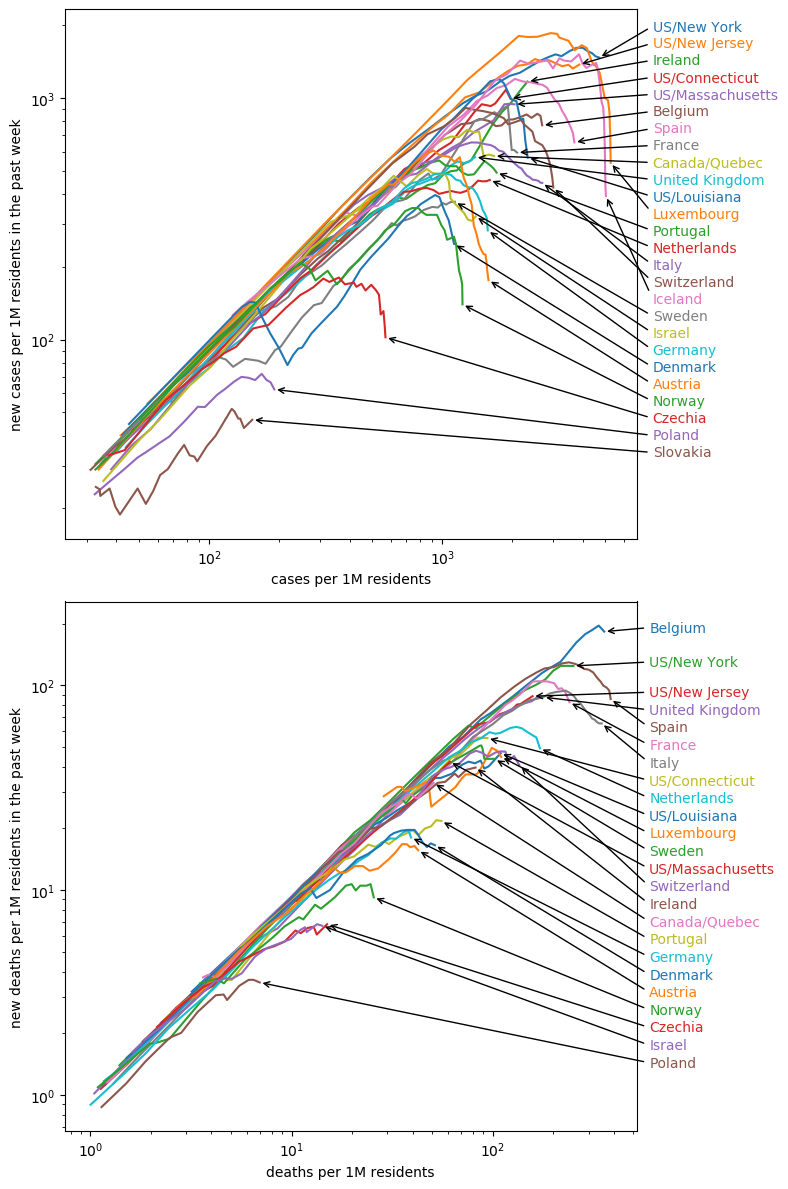

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
params = [
    ('cases', axes[0], 8_000, 1.3, 30, 0.85),
    ('deaths', axes[1], 600, 1, 1, 0.82)
]
for kind, ax, edge, start, thre, step in params:
    payload = [
        (
            key,
            df_i[kind].to_frame('total')
            .assign(delta=lambda x: x['total'].diff())
            .iloc()[1:]
            .loc()[lambda x: x['delta'] > 0]
            .assign(smdelta=lambda x: x['delta'].rolling(7).sum())
        )
        for key, df_i in query.groupby(['Country/Region', 'Province/State'])
    ]
    payload = sorted(
        payload,
        key=lambda x: x[1].iloc()[-1]['smdelta'],
        reverse=True)
    prev_y_annot = np.inf
    for i, (key, df_i) in enumerate(payload):
        if kind == 'deaths' and key[0] == 'Iceland':
            continue
        label = '/'.join(key) if key[1] else key[0]
        color = COLORS[i % len(COLORS)]
        df_i = df_i.loc()[lambda x: x['total'] >= thre]
        df_i.plot('total', 'smdelta', ax=ax, label=label, c=color)
        if not len(df_i):
            continue
        last_i = df_i.iloc()[-1]
        prev_y_annot = min(start * last_i['smdelta'], step * prev_y_annot)
        ax.annotate(
            label,
            (last_i['total'], last_i['smdelta']),
            xytext=(edge, prev_y_annot),
            color=color,
            arrowprops={
                'arrowstyle': '->',
                'relpos': (0, 0.5),
            },
        )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'{kind} per 1M residents')
    ax.set_ylabel(f'new {kind} per 1M residents in the past week')
    ax.get_legend().remove()
fig.tight_layout()

In [10]:
fig.savefig('figure.svg')